In [1]:
from __future__ import absolute_import, division, print_function

import os
import cv2
import numpy as np
import skimage.io
from skimage.transform import resize
import tensorflow as tf

# Our implementation of ConvNet layers and Compact Bilinear in TensorFlow
from vqa_mcb_model import vqa_mcb_model

# For ResNet, we (currently) still use Caffe to extract image features.
# We DO NOT need the vqa Caffe branch. You can use standard Caffe for ResNet.
import sys; sys.path.append('/home/ronghang/workspace/caffe-vqa-mcb/python')
import caffe

# For loading data, we use the LoadVQADataProvider in original code
import vqa_data_provider_layer
from vqa_data_provider_layer import LoadVQADataProvider

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# constants
GPU_ID = 2
RESNET_MEAN_PATH = "../preprocess/ResNet_mean.binaryproto"
RESNET_LARGE_PROTOTXT_PATH = "../preprocess/ResNet-152-448-deploy.prototxt"
RESNET_CAFFEMODEL_PATH = "../data/resnet/ResNet-152-model.caffemodel"
EXTRACT_LAYER = "res5c"
EXTRACT_LAYER_SIZE = (2048, 14, 14)
TARGET_IMG_SIZE = 448
VDICT_PATH = "../data/multi_att_2_glove_pretrained/vdict.json"
ADICT_PATH = "../data/multi_att_2_glove_pretrained/adict.json"

# To reproduce exactly the same output, the random vectors
# In Caffe's two CompactBilinear layers are extracted
# For training from scratch, you may use other random vectors
# or leave unspecified
CBP0_RAND_FILE = './tf_vqa_data/cbp0_rand.npz'
CBP1_RAND_FILE = './tf_vqa_data/cbp1_rand.npz'

# Converted from the corresponding Caffe model
PRETRAINED_MODEL = './tf_vqa_data/_iter_190000.tfmodel'

In [4]:
# Set GPU with CUDA_VISIBLE_DEVICES environment
# Effective for both TensorFlow and Caffe
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_ID)

# The VQA model

In [5]:
# --- VQA Model Params ---
batch_size = 1
num_vocab = 21025
embed_dim = 300
glove_dim = 300
max_time = 15
lstm_output_dim = 1024
lstm_layers = 2
feat_h, feat_w = 14, 14
img_feat_dim = 2048
cbp0_dim = 16000
cbp1_dim = 16000
num_classes = 3000
apply_dropout = False

cbp0_rand = dict(np.load(CBP0_RAND_FILE))
cbp1_rand = dict(np.load(CBP1_RAND_FILE))

In [6]:
# Create a TensorFlow session that allows GPU memory growth.
# Otherwise it's going to take up all available memory
# on the machine.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

# Input and output Tensors
word_indices = None
glove_vector = None
seq_length = None
img_feature = None
prediction = None
att_softmax0 = None

# Caffe's ResNet for feature extraction
resnet_mean = None
resnet_net = None

# Data Loader
vqa_data_provider = LoadVQADataProvider(VDICT_PATH, ADICT_PATH, batchsize=1,
    mode='test', data_shape=EXTRACT_LAYER_SIZE)

In [7]:
def setup():
    global resnet_mean
    global resnet_net
    
    global word_indices
    global glove_vector
    global seq_length
    global img_feature
    global prediction
    global att_softmax0
    
    # data provider
    vqa_data_provider_layer.CURRENT_DATA_SHAPE = EXTRACT_LAYER_SIZE

    # mean substraction
    blob = caffe.proto.caffe_pb2.BlobProto()
    data = open( RESNET_MEAN_PATH , 'rb').read()
    blob.ParseFromString(data)
    resnet_mean = np.array( caffe.io.blobproto_to_array(blob)).astype(np.float32).reshape(3,224,224)
    resnet_mean = np.transpose(cv2.resize(np.transpose(resnet_mean,(1,2,0)), (448,448)),(2,0,1))

    caffe.set_mode_gpu()

    resnet_net = caffe.Net(RESNET_LARGE_PROTOTXT_PATH, RESNET_CAFFEMODEL_PATH, caffe.TEST)

    # our VQA model in TensorFlow
    word_indices = tf.placeholder(tf.int32, [max_time, batch_size])
    glove_vector = tf.placeholder(tf.float32, [max_time, batch_size, glove_dim])
    seq_length = tf.placeholder(tf.int32, [batch_size])
    img_feature = tf.placeholder(tf.float32, [batch_size, feat_h, feat_w, img_feat_dim])
    prediction, att_softmax0, _ = vqa_mcb_model(word_indices, glove_vector,
        seq_length, img_feature, batch_size, num_vocab, embed_dim, glove_dim, max_time,
        lstm_output_dim, lstm_layers, feat_h, feat_w, img_feat_dim, cbp0_dim, cbp1_dim,
        num_classes, cbp0_rand, cbp1_rand, apply_dropout)
    
    saver = tf.train.Saver()
    saver.restore(sess, PRETRAINED_MODEL)

    print('Finished setup')

In [8]:
def trim_image(img):
    y,x,c = img.shape
    if c != 3:
        raise Exception('Expected 3 channels in the image')
    resized_img = cv2.resize( img, (TARGET_IMG_SIZE, TARGET_IMG_SIZE))
    transposed_img = np.transpose(resized_img,(2,0,1)).astype(np.float32)
    ivec = transposed_img - resnet_mean
    return ivec

def make_rev_adict(adict):
    """
    An adict maps text answers to neuron indices. A reverse adict maps neuron
    indices to text answers.
    """
    rev_adict = {}
    for k,v in adict.items():
        rev_adict[v] = k
    return rev_adict

def softmax(arr):
    e = np.exp(arr)
    dist = e / np.sum(e)
    return dist

def downsample_image(img):
    img_h, img_w, img_c = img.shape
    img = resize(img, (448 * img_h // img_w, 448))
    return img

def visualize_attention(source_img_path, att_map):
    """
    Visualize the attention map on the image and save the visualization.
    """
    img = skimage.io.imread(source_img_path)
    
    # downsample source image
    img = downsample_image(img)
    img_h, img_w, img_c = img.shape

    _, att_h, att_w, _ = att_map.shape
    att_map = att_map.reshape((att_h, att_w))

    # upsample attention map to match original image
    upsample0 = resize(att_map, (img_h, img_w), order=3) # bicubic interpolation
    upsample0 = upsample0 / upsample0.max()

    # create rgb-alpha 
    rgba0 = np.zeros((img_h, img_w, img_c + 1))
    rgba0[..., 0:img_c] = img
    rgba0[..., 3] = upsample0

    return rgba0

def extract_image_feature(image_path):
    img = cv2.imread(image_path)
    preprocessed_img = trim_image(img)
    resnet_net.blobs['data'].data[0,...] = preprocessed_img
    resnet_net.forward()
    feature = resnet_net.blobs[EXTRACT_LAYER].data[0].reshape(EXTRACT_LAYER_SIZE)
    feature = ( feature / np.sqrt((feature**2).sum()) )

    return feature

def answer_question(question, img_feature_val):
    qvec, cvec, avec, glove_matrix = vqa_data_provider.create_batch(question)
    
    # In TensorFlow, instead of putting the question at the end
    # we put it at the beginning, and perform dynamic computation    
    valid_time_idx = qvec.reshape(-1) > 0
    word_indices_val = qvec[:, valid_time_idx].T
    glove_vector_val = glove_matrix[:, valid_time_idx, :].transpose((1,0,2))
    seq_length_val = np.sum(valid_time_idx)
    # Put dummy zeros after the sequence length using dynamic_rnn
    word_indices_val = np.concatenate((word_indices_val, np.zeros((max_time-seq_length_val, 1)))).astype(np.int32)
    glove_vector_val = np.concatenate((glove_vector_val, np.zeros((max_time-seq_length_val, 1, glove_dim))))
    img_feature_val = img_feature_val[np.newaxis, ...].transpose((0, 2, 3, 1))
        
    # Forward Pass
    scores, att_map = sess.run([prediction, att_softmax0],
                               feed_dict={word_indices: word_indices_val,
                                          glove_vector: glove_vector_val,
                                          seq_length: [seq_length_val],
                                          img_feature: img_feature_val})
    scores = softmax(np.squeeze(scores))
    top_indices = scores.argsort()[::-1][:5]
    top_answers = [vqa_data_provider.vec_to_answer(i) for i in top_indices]
    top_scores = [float(scores[i]) for i in top_indices]

    return scores, top_indices, top_answers, att_map

In [9]:
setup()

Finished setup


# Run on one image

In [10]:
image_path = 'example_image.jpg'
question = 'how many cups are there in the image?'

Question: how many cups are there in the image?
Top answers:
2 (prob = 0.348016)
3 (prob = 0.329348)
4 (prob = 0.090166)
5 (prob = 0.072210)
1 (prob = 0.056934)


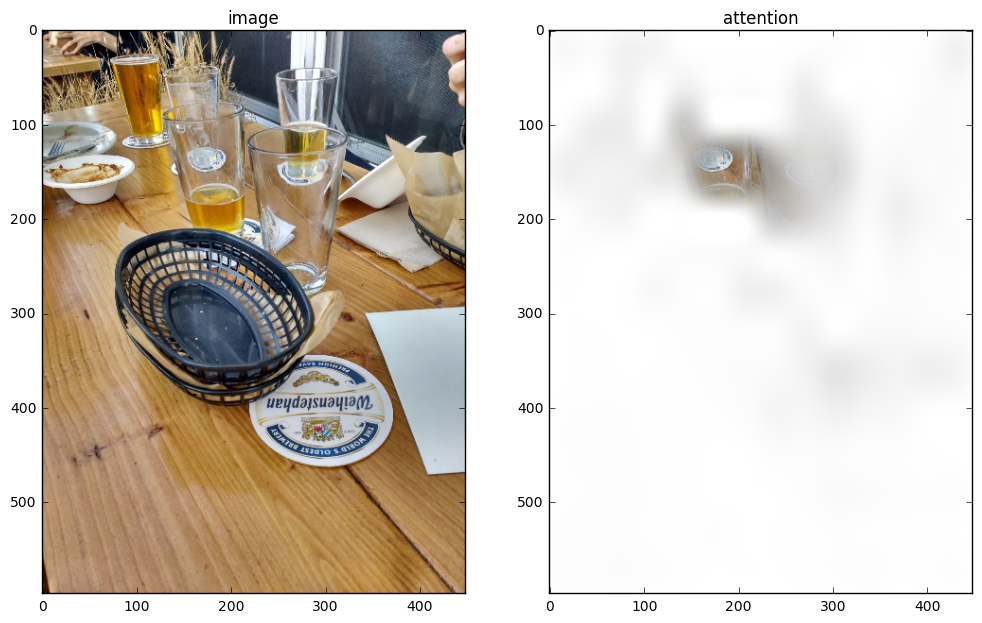

In [11]:
img_feature_val = extract_image_feature(image_path)
scores, top_indices, top_answers, att_map = answer_question(question, img_feature_val)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(downsample_image(plt.imread(image_path)))
plt.subplot(1, 2, 2)
plt.imshow(visualize_attention(image_path, att_map))
plt.title("attention")

print("Question:", question)
print("Top answers:")
for i in range(len(top_answers)):
    print(top_answers[i], '(prob = %f)' % scores[top_indices[i]])